# SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.


**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
# ! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
def plot_example(data, target):
  """Plot the first 5 images and their labels in a row."""
  for i, (img, target) in enumerate(zip(data[:5], target[:5])):
    img = img.reshape(50, 50)
    plt.subplot(151 + i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(target)

## Preprocessing Data

Nessa primeira etapa, vamos comparar 4 datasets em uma rede neural simples:

**1) ESC-10_original_espectrogramas_50x50.csv:** espectrogramas de 50 por 50 pixels

**2) ESC-10_original_espectrogramas_100x100.csv:** espectrogramas de 100 por 100 pixels

**3) ESC-10_original.csv:** features que não são espectrogramas

O Skorch não trabalha com mais de uma separação de treinamento e teste pq o fit demora muito. Então eu criei a função abaixo para fazer o split baseado no que o dataset forneceu. Como não é possível fazer o KFold completo, vou separar tudo que é da primeira pasta para teste e o restante para treinamento.


In [31]:
def ajustarDataset(caminhoCSV):
  
  # ABRINDO O DATASET
  dataset = pd.read_csv(caminhoCSV).to_numpy()

  # SEPARANDO DATA, TARGET E O NOME DOS ARQUIVOS (A PASTA DO KFOLD ESTA NO NOME DOS ARQUIVOS)
  data     = dataset[:,1:-1]
  target   = dataset[:,-1]
  arquivos = dataset[:,0]

  # PASSANDO O TARGET PARA VALORES NUMERICOS
  classes = list(np.unique(target))
  for i, yAtual in enumerate(target):
    target[i] = classes.index(yAtual)

  # SEPARANDO TRAIN E TEST
  xTrain, xTest, yTrain, yTest = [], [], [], []
  for (xAtual, yAtual, arquivoAtual) in zip(data, target, arquivos):
    
    if arquivoAtual[:-4].split("_")[2] == "1":
      xTest.append(xAtual)
      yTest.append(yAtual)
    else:
      xTrain.append(xAtual)
      yTrain.append(yAtual)   

  return np.array(xTrain).astype('float32'), np.array(xTest).astype('float32'), np.array(yTrain).astype('int64'), np.array(yTest).astype('int64')

# 1) ESC-10_original_espectrogramas_50x50.csv




In [32]:
xTrain, xTest, yTrain, yTest = ajustarDataset("/content/drive/My Drive/datasets/ESC_10_16kHz_8bits/original/ESC-10_original_espectrogramas_50x50.csv")

In [33]:
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((320, 2500), (80, 2500), (320,), (80,))

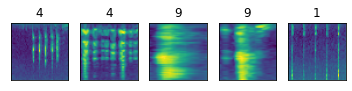

In [34]:
plot_example(xTest, yTest)

### Construindo a rede neural

In [35]:
class ClassifierModule(nn.Module): # HERANCA DE NN.MODULE
    def __init__(self, dimensionalidadeInputLayer, dimensionalidadeHiddenLayer, dimensionalidadeOutputLayer, dropout=0.5):
        super(ClassifierModule, self).__init__() # SUPER EH A CLASSE PAI
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(dimensionalidadeInputLayer, dimensionalidadeHiddenLayer)
        self.output = nn.Linear(dimensionalidadeHiddenLayer, dimensionalidadeOutputLayer)

    def forward(self, X, **kwargs):
        X = functional.relu(self.hidden(X))
        X = self.dropout(X)
        X = functional.softmax(self.output(X), dim=-1)
        return X

In [46]:
# SETANDO A TOPOLOGIA DA REDE
dimensionalidadeInputLayer  = xTrain.shape[1]
dimensionalidadeHiddenLayer = int(dimensionalidadeInputLayer/8)
dimensionalidadeOutputLayer = len(np.unique(yTrain))

# OUTROS PARAMETROS INICIAIS
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CRIANDO A REDE COM O MODELO CONSTRUIDO ANTERIORMENTE
net = NeuralNetClassifier(
    ClassifierModule(dimensionalidadeInputLayer, dimensionalidadeHiddenLayer, dimensionalidadeOutputLayer),
    max_epochs=2500,
    lr=0.001,
    device=device,
    train_split=None,
)

# TREINANDO
net.fit(X=xTrain, y=yTrain)

# PREDIZENDO
yPred = net.predict(xTest)

# ACURACIA
acuracia = accuracy_score(list(yTest), list(yPred))
print("\nAcurácia:", acuracia)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3398  0.0213
      2        2.2076  0.0238
      3        2.0458  0.0220
      4        1.9336  0.0216
      5        1.8822  0.0224
      6        1.7868  0.0217
      7        1.7202  0.0222
      8        1.6501  0.0222
      9        1.6251  0.0221
     10        1.5759  0.0213
     11        1.5462  0.0222
     12        1.5035  0.0215
     13        1.4799  0.0221
     14        1.4165  0.0219
     15        1.4058  0.0203
     16        1.3969  0.0198
     17        1.3629  0.0206
     18        1.3289  0.0193
     19        1.3120  0.0194
     20        1.2904  0.0196
     21        1.2723  0.0217
     22        1.2426  0.0221
     23        1.2195  0.0216
     24        1.2032  0.0204
     25        1.1989  0.0199
     26        1.1593  0.0205
     27        1.1552  0.0203
     28        1.1376  0.0180
     29        1.1307  0.0194
     30        1.1162  0.0181
     31        1.1091  0.0191
     32   

Vamos dar uma bizoiada nas amostras que foram classificadas erroneamente



In [38]:
error_mask = yPred != yTest

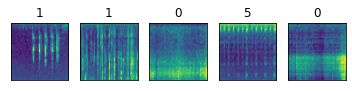

In [39]:
plot_example(xTest[error_mask], yPred[error_mask])

# 2) ESC-10_original_espectrogramas_100x100.csv

In [47]:
# ABRINDO O DATASET E FAZENDO O SPLIT
xTrain, xTest, yTrain, yTest = ajustarDataset("/content/drive/My Drive/datasets/ESC_10_16kHz_8bits/original/ESC-10_original_espectrogramas_100x100.csv")

# SETANDO A TOPOLOGIA DA REDE
dimensionalidadeInputLayer  = xTrain.shape[1]
dimensionalidadeHiddenLayer = int(dimensionalidadeInputLayer/8)
dimensionalidadeOutputLayer = len(np.unique(yTrain))

# CRIANDO A REDE COM O MODELO CONSTRUIDO ANTERIORMENTE
net = NeuralNetClassifier(
    ClassifierModule(dimensionalidadeInputLayer, dimensionalidadeHiddenLayer, dimensionalidadeOutputLayer),
    max_epochs=2500,
    lr=0.001,
    device=device,
    train_split=None,
)

# TREINANDO
net.fit(X=xTrain, y=yTrain)

# PREDIZENDO
yPred = net.predict(xTest)

# ACURACIA
acuracia = accuracy_score(list(yTest), list(yPred))
print("\nAcurácia:", acuracia)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3398  0.0243
      2        2.2076  0.0300
      3        2.0458  0.0229
      4        1.9336  0.0233
      5        1.8822  0.0218
      6        1.7868  0.0220
      7        1.7202  0.0225
      8        1.6501  0.0217
      9        1.6251  0.0211
     10        1.5759  0.0211
     11        1.5462  0.0226
     12        1.5035  0.0216
     13        1.4799  0.0219
     14        1.4165  0.0219
     15        1.4058  0.0209
     16        1.3969  0.0207
     17        1.3629  0.0204
     18        1.3289  0.0199
     19        1.3120  0.0196
     20        1.2904  0.0209
     21        1.2723  0.0207
     22        1.2426  0.0204
     23        1.2195  0.0193
     24        1.2032  0.0201
     25        1.1989  0.0203
     26        1.1593  0.0200
     27        1.1552  0.0192
     28        1.1376  0.0195
     29        1.1307  0.0183
     30        1.1162  0.0185
     31        1.1091  0.0193
     32   

# 3) ESC-10_original.csv 

In [48]:
# ABRINDO O DATASET E FAZENDO O SPLIT
xTrain, xTest, yTrain, yTest = ajustarDataset("/content/drive/My Drive/datasets/ESC_10_16kHz_8bits/original/ESC-10_original.csv")

# SETANDO A TOPOLOGIA DA REDE
dimensionalidadeInputLayer  = xTrain.shape[1]
dimensionalidadeHiddenLayer = int(dimensionalidadeInputLayer/8)
dimensionalidadeOutputLayer = len(np.unique(yTrain))

# CRIANDO A REDE COM O MODELO CONSTRUIDO ANTERIORMENTE
net = NeuralNetClassifier(
    ClassifierModule(dimensionalidadeInputLayer, dimensionalidadeHiddenLayer, dimensionalidadeOutputLayer),
    max_epochs=2500,
    lr=0.001,
    device=device,
    train_split=None,
)

# TREINANDO
net.fit(X=xTrain, y=yTrain)

# PREDIZENDO
yPred = net.predict(xTest)

# ACURACIA
acuracia = accuracy_score(list(yTest), list(yPred))
print("\nAcurácia:", acuracia)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3571  0.1828
      2        2.3387  0.1891
      3        2.3230  0.1897
      4        2.3063  0.1890
      5        2.2923  0.1825
      6        2.2789  0.1832
      7        2.2596  0.1900
      8        2.2453  0.1846
      9        2.2313  0.2101
     10        2.2153  0.1829
     11        2.1981  0.1867
     12        2.1875  0.1891
     13        2.1724  0.1813
     14        2.1632  0.1932
     15        2.1500  0.1826
     16        2.1320  0.1886
     17        2.1196  0.2007
     18        2.1038  0.1860
     19        2.0925  0.1896
     20        2.0743  0.1856
     21        2.0654  0.1840
     22        2.0517  0.1961
     23        2.0396  0.1859
     24        2.0257  0.1960
     25        2.0130  0.1828
     26        1.9922  0.1870
     27        1.9836  0.1892
     28        1.9712  0.1865
     29        1.9539  0.1894
     30        1.9458  0.1913
     31        1.9324  0.1992
     32   

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. Dataset data has only one channel. As stated above, each data vector represents a 50x50 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 50, 50). 

# 1) ESC-10_original_espectrogramas_50x50.csv

In [51]:
xTrain, xTest, yTrain, yTest = ajustarDataset("/content/drive/My Drive/datasets/ESC_10_16kHz_8bits/original/ESC-10_original_espectrogramas_50x50.csv")
xCNNTrain = xTrain.reshape(-1, 1, 50, 50)
xCNNTest  = xTest.reshape(-1, 1, 50, 50)
xCNNTrain.shape, xCNNTest.shape

((320, 1, 50, 50), (80, 1, 50, 50))

In [55]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(7744, 100) # 7744 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(functional.max_pool2d(self.conv1(x), 2))
        x = torch.relu(functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [68]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=2500,
    lr=0.001,
    optimizer=torch.optim.Adam,
    device=device,
    train_split=None,
)

In [69]:
cnn.fit(xCNNTrain, yTrain);

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2272  0.0383
      2        1.8149  0.0386
      3        1.4861  0.0392
      4        1.3415  0.0415
      5        1.2535  0.0398
      6        1.0711  0.0382
      7        1.0695  0.0342
      8        0.9896  0.0298
      9        0.9251  0.0312
     10        0.8497  0.0321
     11        0.8225  0.0302
     12        0.7662  0.0301
     13        0.7736  0.0299
     14        0.7031  0.0296
     15        0.7166  0.0283
     16        0.6447  0.0293
     17        0.6337  0.0284
     18        0.5894  0.0285
     19        0.5444  0.0300
     20        0.5687  0.0298
     21        0.5462  0.0295
     22        0.4777  0.0283
     23        0.5054  0.0286
     24        0.5135  0.0287
     25        0.4967  0.0287
     26        0.4431  0.0295
     27        0.4406  0.0285
     28        0.3716  0.0281
     29        0.3776  0.0296
     30        0.3486  0.0294
     31        0.3626  0.0299
     32   

In [70]:
yPredCNN = cnn.predict(xCNNTest)

In [71]:
accuracy_score(list(yTest), list(yPredCNN))

0.6875

Let's see how we fare on the examples that went wrong before:


In [72]:
accuracy_score(list(yTest[error_mask]), list(yPredCNN[error_mask]))

0.3103448275862069

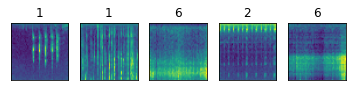

In [73]:
plot_example(xTest[error_mask], yPredCNN[error_mask])

# 2) ESC-10_original_espectrogramas_100x100.csv

In [75]:
xTrain, xTest, yTrain, yTest = ajustarDataset("/content/drive/My Drive/datasets/ESC_10_16kHz_8bits/original/ESC-10_original_espectrogramas_100x100.csv")
xCNNTrain = xTrain.reshape(-1, 1, 100, 100)
xCNNTest  = xTest.reshape(-1, 1, 100, 100)

# CONSTRUINDO O MODELO
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(33856, 100) # 7744 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(functional.max_pool2d(self.conv1(x), 2))
        x = torch.relu(functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

torch.manual_seed(0)

# INSTANCIANDO O OBJETO DA REDE NEURAL
cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=2500,
    lr=0.001,
    optimizer=torch.optim.Adam,
    device=device,
    train_split=None,
)

cnn.fit(xCNNTrain, yTrain)

# PREDIZENDO
yPredCNN = cnn.predict(xCNNTest)

# ACURACIA
print(accuracy_score(list(yTest), list(yPredCNN)))

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3373  0.1161
      2        1.8495  0.1105
      3        1.4614  0.1017
      4        1.3848  0.0884
      5        1.1238  0.0849
      6        0.9971  0.0852
      7        0.9811  0.0854
      8        0.8442  0.0857
      9        0.8000  0.0848
     10        0.6776  0.0870
     11        0.6180  0.0867
     12        0.6577  0.0880
     13        0.5302  0.0874
     14        0.5284  0.0877
     15        0.4900  0.0861
     16        0.4820  0.0872
     17        0.4004  0.0851
     18        0.3450  0.0856
     19        0.3189  0.0877
     20        0.3971  0.0853
     21        0.3842  0.0853
     22        0.3471  0.0871
     23        0.3476  0.0861
     24        0.2565  0.0856
     25        0.3225  0.0874
     26        0.2661  0.0869
     27        0.2442  0.0862
     28        0.2331  0.0871
     29        0.2152  0.0853
     30        0.2111  0.0857
     31        0.2173  0.0880
     32   